# Feed Forward Neural Network
**Using Neural Networks to predict essay grades using vectorized essays** 

We use neural networks to predict the grade of the essay by training on 90% of the data and testing on 10% of the data. The neural network works using 3 layers, with one input layer, two layers on neurons and with one output node. 

Let's look at the architecture, initialization and cost.

In [1]:
%%capture
from essay2vec import *;

**Weight and Bias Variable**

A neural network works on a linear summation of biases and product of weights and data of that layer. 

Y = W*x + b

The weights are initialized as shape of [previous layer, next layer], initialized to a value of 0.1. These weights will be updated while the neural network is trained; the weights are optimized with the increasing number of epochs, this helps with accurate predictions of the training and test response variables.

The biases are initialized as the shape of [next layer]. Similar the weights, the biases are optimized with the increasing number of epochs during the training. 

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

**Neural Network Architecture**

Below is our feed forward neural network architecture. It starts with number of input nodes equal to the number of features of the training essays. So 300 input nodes exist. This feeds into a layer of 500 nodes, the input to this nodes is are activated by ReLU function, this is achieved by matrix operation of weights, input nodes and biases. Now the layer 1, feeds into 750 nodes, and this is activated using a ReLU function as well. Lastly, there is one output node. The output node produces a regression output. 

To optimize the model, the loss function use is the Mean Square Error of the predicted grade versus the actual grade. The loss function is optimized using the Adam Optimizer which best trains the model.

In [3]:
batch_size = 300
hidden_nodes_1 = 500
hidden_nodes_2 = 750
size = testDataVecs.shape[1]

graph = tf.Graph()
with graph.as_default():

    # Input data.
    with tf.name_scope("Input"):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
    tf_test_dataset = tf.constant(testDataVecs)
      
    layer1_weights = weight_variable([size, hidden_nodes_1])
    layer1_biases = bias_variable([hidden_nodes_1]) 
    
    layer2_weights = weight_variable([hidden_nodes_1, hidden_nodes_2])
    layer2_biases = bias_variable([hidden_nodes_2])
    
    layer3_weights = weight_variable([hidden_nodes_2, 1])
    layer3_biases = bias_variable([1])
    
    def model(data):
        with tf.name_scope("Layer_1"):
            layer1 = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
        
        with tf.name_scope("Layer_2"):
            
            layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)

        with tf.name_scope("Layer_3"):
            layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        return layer3
    
    # Training computation.
    yhat = model(tf_train_dataset)
    
    with tf.name_scope("Loss"):
        loss = tf.reduce_mean(tf.square(yhat - tf_train_labels))
    
    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.001
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    
    with tf.name_scope("Train"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    tf.scalar_summary("loss", loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = yhat
    test_prediction = model(tf_test_dataset)

**Training and Testing Prediction**

Now the neural network trains on batches of data and minimizes error to optimize the learning rate, weights and biases for each of the layer to calculate the best accuracy. We calculate accuracy for each epoch by calculating the spearman correlation at each epoch and then calculating the spearman score for all the test set grades.

In [4]:
test_preds = pd.DataFrame()
# Re-define the function to include the keep probability
l_array = []
start = timeit.timeit()
num_epochs = 3001
def run_session(num_epochs, name):
    with tf.Session(graph=graph) as session:
        writer = tf.train.SummaryWriter("logs/", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = trainDataVecs[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size)]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            l_array.append(l)
            if (epoch % 500 == 0):
                print("Minibatch Loss at Epoch {}: {:.3f}".format(epoch, l))
                rho, pval = (spearmanr(predictions, batch_labels))
                print("Minibatch Spearman Score: {:.4f}".format(rho))
        final_rho, pval = spearmanr(test_prediction.eval(), y_test)
        print("Test Spearman Score: {:.4f}".format(final_rho))
        test_preds[name] = test_prediction.eval().ravel()
        filesave = np.zeros((len(y_test), 2))
        to_use = test_prediction.eval()
        
        for ii in range(len(y_test)):           
            filesave[ii, 0] = y_test[ii]
            filesave[ii, 1] = to_use[ii]
        
        np.savetxt('savetest.txt', filesave, delimiter=",", fmt="%d") 
        
run_session(num_epochs, "Deep_NN")
total = timeit.timeit() - start

Initialized
Minibatch Loss at Epoch 0: 154.912
Minibatch Spearman Score: 0.2293
Minibatch Loss at Epoch 500: 6.415
Minibatch Spearman Score: 0.9101
Minibatch Loss at Epoch 1000: 3.539
Minibatch Spearman Score: 0.9542
Minibatch Loss at Epoch 1500: 2.042
Minibatch Spearman Score: 0.9485
Minibatch Loss at Epoch 2000: 3.022
Minibatch Spearman Score: 0.9329
Minibatch Loss at Epoch 2500: 1.545
Minibatch Spearman Score: 0.9439
Minibatch Loss at Epoch 3000: 1.913
Minibatch Spearman Score: 0.9655
Test Spearman Score: 0.9369


**Loss vs Epoch**

As expected in the graph below, the loss is minimized with increasing number of epochs. This means that our loss function of MSE was reduced in the training to give the optimal answer. 

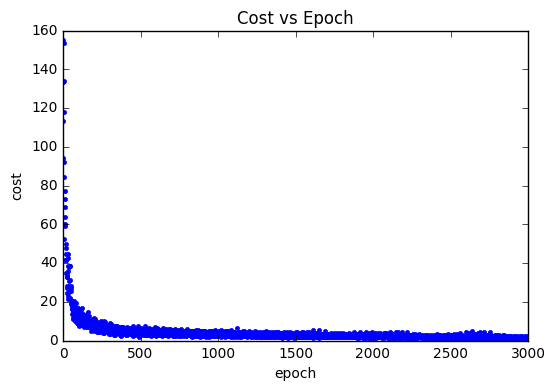

In [5]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Cost vs Epoch")
plt.show()

**Results**

Having tested the Neural Network on 10% of the data and trained on 90% of the data, we get the highest Spearman score of 0.9369, with fairly low computation time. These are fantastic results meaning that there is high accuracy from our model. 